In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import sympy
import pickle
from sklearn.metrics import r2_score
import importlib


from DAG_search import utils
from DAG_search import dag_search
from DAG_search import comp_graph

## Bug: Gradients of Multivariate Functions

In [ ]:
# TODO

## Speedup

In [41]:
%load_ext pyinstrument

In [167]:
X = np.random.rand(1000, 1)
y = np.random.rand(1000)

est = dag_search.DAGRegressor(k = 1, n_calc_nodes = 2, max_orders = int(1e3))

In [12]:
%%pyinstrument
est.fit(X, y, verbose = 0)

DAGRegressor(max_orders=1000, n_calc_nodes=2, positives=array([ True]))

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:34:46  Samples:  32175
 /_//_/// /_\ / //_// / //_'/ //     Duration: 33.333    CPU time: 31.047
/   _/                      v4.6.2

Program: C:\Users\Paul Kahlmeyer\anaconda3\envs\SymbReg\lib\site-packages\ipykernel_launcher.py -f C:\Users\Paul Kahlmeyer\AppData\Roaming\jupyter\runtime\kernel-a0361ae3-c4e6-48ef-973c-81f1b6793963.json

33.344 <cell line: 2>  ..\..\..\AppData\Local\Temp\ipykernel_24216\2300451065.py:2
`- 33.344 DAGRegressor.fit  dag_search.py:1711
   `- 33.335 exhaustive_search  dag_search.py:1046
      `- 33.319 evaluate_build_order  dag_search.py:768
         `- 32.933 evaluate_cgraph  dag_search.py:717
            `- 32.908 get_consts_grid_zoom  dag_search.py:384
               `- 32.611 get_consts_grid  dag_search.py:346
                  |- 21.981 MSE_loss_fkt.__call__  dag_search.py:68
                  |  |- 15.791 CompGraph.evaluate  comp_graph.py:471
                  |  |  |- 8.705 [self]  comp_graph.py
                  |  |  |- 3.237 repeat  numpy\core\fromnumeric.py:423
                  |  |  |     [3 frames hidden]  numpy, <built-in>
                  |  |  |- 0.994 stack  numpy\core\shape_base.py:372
                  |  |  |     [2 frames hidden]  numpy
                  |  |  |- 0.519 simplefilter  warnings.py:165
                  |  |  `- 0.350 <lambda>  config.py:17
                  |  |- 2.721 mean  numpy\core\fromnumeric.py:3385
                  |  |     [4 frames hidden]  numpy, <built-in>
                  |  `- 2.632 [self]  dag_search.py
                  |- 6.054 stack  numpy\core\shape_base.py:372
                  |     [7 frames hidden]  numpy, <built-in>
                  |- 1.570 linspace  numpy\core\function_base.py:24
                  |     [2 frames hidden]  numpy
                  |- 1.068 [self]  dag_search.py
                  |- 1.026 meshgrid  numpy\lib\function_base.py:5011
                  |     [2 frames hidden]  numpy
                  `- 0.389 column_stack  numpy\lib\shape_base.py:612

## Bottleneck: Evaluation

In [118]:
import importlib
importlib.reload(comp_graph)

<module 'DAG_search.comp_graph' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\DAG_search\\comp_graph.py'>

In [119]:
# (x_0 + x1)**2


node_dict = {
    0 : ([], 'inp'),
    1 : ([], 'inp'),
    2 : ([], 'const'),
    3 : ([4, 4], '*'),
    4 : ([0, 1], '+')
}

graph = comp_graph.CompGraph(m = 2, n = 1, k = 1, node_dict = node_dict)
graph.evaluate_symbolic()[0]

(x_0 + x_1)**2

In [122]:
X = np.random.rand(10000, 2)
c = np.random.rand(50, 1)

In [123]:
pred1 = graph.evaluate(X, c)
pred11, grad1 = graph.evaluate(X, c, return_grad = True)
assert np.allclose(pred1, pred11)
pred1.shape, grad1.shape

((50, 10000, 1), (50, 1, 10000, 2))

In [124]:
%timeit pred1 = graph.evaluate(X, c)
%timeit pred11, grad1 = graph.evaluate(X, c, return_grad = True)

2.84 ms ± 94.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.1 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
pred2 = graph.evaluate_old3(X, c)
pred21, grad2 = graph.evaluate_old3(X, c, return_grad = True)
assert np.allclose(pred2, pred21)
pred2.shape, grad2.shape

((50, 10000, 1), (50, 1, 10000, 2))

In [126]:
%timeit pred2 = graph.evaluate_old3(X, c)
%timeit pred21, grad2 = graph.evaluate_old3(X, c, return_grad = True)

9.97 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.5 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [128]:
np.allclose(pred1, pred2), np.allclose(grad1, grad2)

(True, True)

In [129]:
def eval1(X, c):
    eval_str = '(X_full[:, :, 0] + X_full[:, :, 1])**2'
    X_full = np.broadcast_to(X, (c.shape[0], X.shape[0], X.shape[1])) # r x N x m
    c_full = np.broadcast_to(c[:, None, :], (c.shape[0], X.shape[0], c.shape[1])) # r x N x k
    res = eval(eval_str)
    return res[:, :, np.newaxis]

%timeit pred_np = eval1(X, c)

2.93 ms ± 44.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
eval_str = '(X[:, :, 0] + X[:, :, 1])**2'
exp_as_func = eval('lambda X, c: ' + eval_str)

def eval2(X, c):
    
    X_full = np.broadcast_to(X, (c.shape[0], X.shape[0], X.shape[1])) # r x N x m
    c_full = np.broadcast_to(c[:, None, :], (c.shape[0], X.shape[0], c.shape[1])) # r x N x k
    res = exp_as_func(X_full, c_full)
    return res[:, :, np.newaxis]

%timeit pred_np = eval2(X, c)

2.82 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
# optimal
def eval3(X, c):
    X_full = np.broadcast_to(X, (c.shape[0], X.shape[0], X.shape[1])) # r x N x m
    c_full = np.broadcast_to(c[:, None, :], (c.shape[0], X.shape[0], c.shape[1])) # r x N x k
    res = (X_full[:, :, 0] + X_full[:, :, 1])**2
    return res[:, :, np.newaxis]

%timeit pred_np = eval3(X, c)

2.84 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [132]:
eval_str = compile('(X_full[:, :, 0] + X_full[:, :, 1])**2', '<string>', 'eval')

def eval4(X, c):
    
    X_full = np.broadcast_to(X, (c.shape[0], X.shape[0], X.shape[1])) # r x N x m
    c_full = np.broadcast_to(c[:, None, :], (c.shape[0], X.shape[0], c.shape[1])) # r x N x k
    res = eval(eval_str)
    return res[:, :, np.newaxis]

pred_np = eval4(X, c)

In [133]:
%timeit pred_np = eval4(X, c)

2.85 ms ± 84.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [134]:
%%pyinstrument
for _ in range(1000):
    pred2 = graph.evaluate(X, c)

_     ._   __/__   _ _  _  _ _/_   Recorded: 15:07:08  Samples:  1004
 /_//_/// /_\ / //_// / //_'/ //     Duration: 3.250     CPU time: 2.828
/   _/                      v4.6.2

Program: C:\Users\Paul Kahlmeyer\anaconda3\envs\SymbReg\lib\site-packages\ipykernel_launcher.py -f C:\Users\Paul Kahlmeyer\AppData\Roaming\jupyter\runtime\kernel-a0361ae3-c4e6-48ef-973c-81f1b6793963.json

3.247 <cell line: 2>  ..\..\..\AppData\Local\Temp\ipykernel_22352\2566917897.py:2
`- 3.247 CompGraph.evaluate  comp_graph.py:706
   `- 3.243 <module>  <string>:1

In [173]:
X.shape # N x m -> r x N x m
r = c.shape[0]

In [174]:
X_full1 = np.repeat(X[np.newaxis, :, :], r, axis=0) # r x N x m
X_full1.shape

(50, 1000, 1)

In [178]:
%timeit X_full1 = np.repeat(X[np.newaxis, :, :], r, axis=0) # r x N x m

14.9 µs ± 518 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [177]:
X_full2 = np.broadcast_to(X, (r,) + X.shape)
X_full2.shape

(50, 1000, 1)

In [179]:
%timeit X_full2 = np.broadcast_to(X, (r,) + X.shape)

5.06 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [182]:
c.shape

(50, 2)

In [184]:
c_full = np.broadcast_to(c[:, None, :], (c.shape[0], X.shape[0], c.shape[1]))
c_full.shape

(50, 1000, 2)

## Ideas

#### Coverage of Search Space
Space of small DAGs is enough to approximate smooth functions. 
Experiment: 
- choose high order polynomial, try to approximate
- we are able to compress difficult functions (e.g. NN? efficient+accurate inference)
- **Unbiased**

#### Scaling Up Augmentations
- If we can predict approximate expression size for regression problem: choose Augmentations that make expression size smaller
- AIFeynman Symmetries
- Correlation of Oracle vs. actual complexity

#### Better Language
Maybe vectorized instructions?


# Coverage of Search Space

**Idea:** Any expression with a lot of nodes is already approximated well by expressions with few nodes

In [113]:
m = 2
k = 1

vs = [np.linspace(-1, 1, 5)]*m
eval_points = np.column_stack([x.flatten() for x in np.meshgrid(*vs)])

vs = [np.linspace(-1, 1, 5)]*k
eval_consts = np.column_stack([x.flatten() for x in np.meshgrid(*vs)])

In [114]:
def collect_function_values(l, eval_points, eval_consts, N = 20000):
    m = eval_points.shape[1]
    k = eval_consts.shape[1]
    ret = []
    expr_set = set()
    for _ in range(N):
        graph = dag_search.sample_graph(m = m, n = 1, k = k, n_calc_nodes = l)
        expr = str(graph.evaluate_symbolic()[0])
        if expr not in expr_set:
            expr_set.add(expr)
            pred = graph.evaluate(eval_points, c = eval_consts)[:, :, 0]
            ret.append(pred)
    return np.row_stack(ret)

from sklearn.metrics.pairwise import pairwise_distances
def get_median_error(base_set, compare_set):
    mask1 = np.all(np.isfinite(base_set), axis = 1)
    mask2 = np.all(np.isfinite(compare_set), axis = 1)
    dist_matrix = pairwise_distances(base_set[mask1], compare_set[mask2])
    return np.median(np.min(dist_matrix, axis = 0))


In [115]:
np.random.seed(0)
n_calc_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
base_sets = []
for l in n_calc_nodes:
    print(l)
    base_set = collect_function_values(l, eval_points, eval_consts)
    base_sets.append(base_set)
    
error_map = np.zeros((len(n_calc_nodes), len(n_calc_nodes)))
for i, l1 in enumerate(n_calc_nodes):
    for j, l2 in enumerate(n_calc_nodes):
        print(i, j)
        error = get_median_error(base_sets[i], base_sets[j])
        error_map[i, j] = error

0
1
2
3
4
5
6
7
8
9
10
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10


Text(0.5, 0, '#Nodes at Inference')

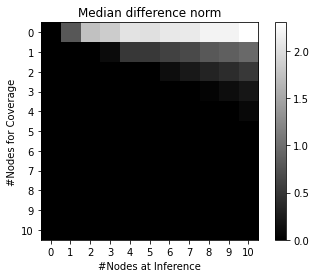

In [116]:
plt.imshow(error_map, cmap = 'gray')
plt.xticks(range(error_map.shape[1]), n_calc_nodes)
plt.yticks(range(error_map.shape[0]), n_calc_nodes)
plt.colorbar()

plt.title('Median difference norm')
plt.ylabel('#Nodes for Coverage')
plt.xlabel('#Nodes at Inference')

# Simplifications

Our samples cover only a small portion of the true function. This becomes worse in higher dimensions.

Hence we should evaluate the heuristics at points with higher density.

**Hypothesis**: This is more robust against noise for detecting true simplifications

In [229]:
def f_true(X):
    tmp = np.sin((X[:, 0]*X[:, 1]))
    return tmp


from sklearn.datasets import make_blobs
centers = np.array([[-1.5, 0.5], [1.5, -0.5]])
X, _ = make_blobs(n_samples = 500, centers = centers, cluster_std = 0.5)
y = f_true(X)

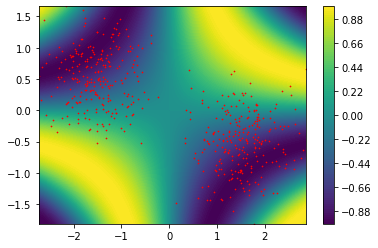

In [230]:
# 1. plot data + true function

# Set up a regular grid of interpolation points


x1, x2 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100), np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
x1, x2 = np.meshgrid(x1, x2)

X_grid = np.column_stack([x1.flatten(), x2.flatten()])
y_grid = f_true(X_grid)
y_grid = y_grid.reshape(x1.shape)
img = plt.contourf(x1, x2, y_grid, levels = 100)

plt.scatter(X[:, 0], X[:, 1], color = 'red', marker = 'x', s = .5)
plt.colorbar(img)

An approximation of the function based on the samples will only be good in regions with a lot of samples

In [231]:
f_appr = simplifications.PolyReg(degree = 10)
#f_appr = simplifications.MLP(verbose = 2)

f_appr.fit(X, y)
pred = f_appr.predict(X)
rmse = np.sqrt(np.mean((y - pred)**2))
print(rmse)

0.00035512162590755264


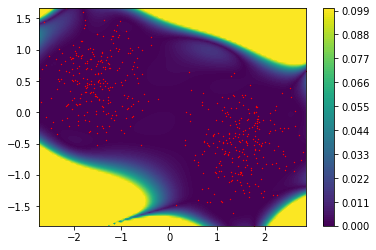

In [232]:
# absolute difference
y_grid_apprx = f_appr.predict(X_grid)
y_grid_apprx = y_grid_apprx.reshape(x1.shape)
y_grid_diff = np.abs((y_grid - y_grid_apprx))

t = 0.1
y_grid_diff[y_grid_diff > t] = t
img = plt.contourf(x1, x2, y_grid_diff, levels = 100)

plt.scatter(X[:, 0], X[:, 1], color = 'red', marker = 'x', s = .2)
plt.colorbar(img)

We can identify these areas using density estimation

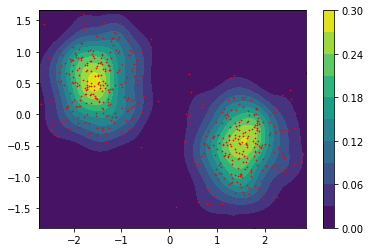

In [233]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# select bandwith using crossvalidation
bandwidths = 10 ** np.linspace(-2, 1, 50) # 0.01 to 10
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(X)

# estimate density
kde = KernelDensity(kernel='gaussian', bandwidth = grid.best_params_['bandwidth']).fit(X)
logprobs = kde.score_samples(X_grid).reshape(x1.shape)


# plot density
img = plt.contourf(x1, x2, np.exp(logprobs), levels = 10)
plt.scatter(X[:, 0], X[:, 1], color = 'red', marker = 'x', s = .5)
plt.colorbar(img)

In [842]:
import pickle

# problem
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen, Univ, Feynman_bonus

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)    

In [843]:
import importlib
importlib.reload(dag_search)
importlib.reload(utils)
importlib.reload(simplifications)

<module 'DAG_search.simplifications' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\DAG_search\\simplifications.py'>

## Investigation

Many times we run into false negatives.

- check fit of candidates

In [847]:
importlib.reload(simplifications)

<module 'DAG_search.simplifications' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\DAG_search\\simplifications.py'>

In [848]:
def get_reduced_sizes(task_dict, noise_level = 0.0, appr = simplifications.approximate_poly):
    np.random.seed(0)
    
    reduced_sizes = []

    for problem_name in tqdm(list(task_dict.keys())):
        X, y, expr = task_dict[problem_name]['X'], task_dict[problem_name]['y'][:, 0], task_dict[problem_name]['expr'][0]

        noise = np.random.normal(scale = noise_level*np.sqrt(np.mean(y**2)), size = len(y))
        y_noise = y + noise

        res = simplifications.find_simplifications(X, y_noise, appr = appr, verbose = 0)
        red_size = simplifications.reduction_size(res, expr)
        reduced_sizes.append(red_size)
    return np.array(reduced_sizes)
    

true_sizes = np.array([task_dict[problem_name]['X'].shape[1] for problem_name in list(task_dict.keys())])

noise_level = 0.0
red_sizes =  get_reduced_sizes(task_dict, noise_level = noise_level)

  0%|          | 0/95 [00:00<?, ?it/s]

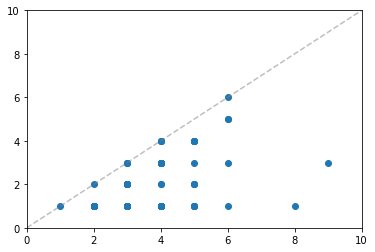

In [851]:
plt.scatter(true_sizes, red_sizes)
max_size = max(true_sizes)
plt.xlim(0, max_size+1)
plt.ylim(0, max_size+1)
plt.plot([0, max_size+1], [0, max_size+1], color = 'tab:gray', alpha = 0.5, linestyle = '--')

Text(0, 0.5, 'Input dimension')

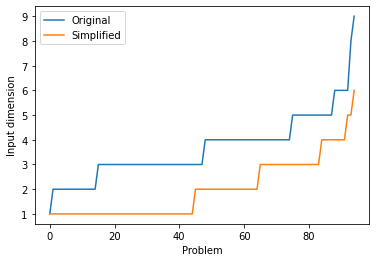

In [852]:
plt.plot(range(len(true_sizes)), np.sort(true_sizes), label = 'Original')
plt.plot(range(len(red_sizes)), np.sort(red_sizes), label = 'Simplified')
plt.legend()
plt.xlabel('Problem')
plt.ylabel('Input dimension')

In [901]:
results = []
noise_levels = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

true_sizes = np.array([task_dict[problem_name]['X'].shape[1] for problem_name in list(task_dict.keys())])
for noise_level in noise_levels:
    print(f'Noise: {noise_level}')
    red_sizes =  get_reduced_sizes(task_dict, noise_level = noise_level)
    results.append(red_sizes)
results = np.stack(results)

Noise: 0.0


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 1e-05


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 0.0001


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 0.001


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 0.01


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 0.1


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 1.0


  0%|          | 0/95 [00:00<?, ?it/s]

Noise: 10.0


  0%|          | 0/95 [00:00<?, ?it/s]

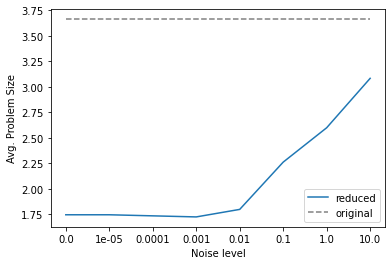

In [905]:
values = np.mean(results, axis = 1)
plt.plot(range(len(values)), values, label = 'reduced')

true_avg = np.mean(true_sizes)
plt.plot([0, len(values)-1], [true_avg, true_avg], color = 'gray', linestyle = '--', label = 'original')
plt.legend()

plt.xticks(range(len(values)), noise_levels)
plt.xlabel('Noise level')
plt.ylabel('Avg. Problem Size')
plt.show()

## How it works

In [906]:
expr = sympy.sympify('x_0/x_1 + 0.25*x_2')
f_true = simplifications.F_true(expr)

X = np.random.rand(1000, 3)
X[:, 1] += 2
y = f_true.predict(X)
expr

x_0/x_1 + 0.25*x_2

In [911]:
importlib.reload(simplifications)
simpl_res = simplifications.find_simplifications(X, y, appr = simplifications.approximate_poly, verbose = 2)

Loss: 2.04880858019843e-14
MultVar: idx=1: 0.21598956571982986
DivVar: idx=1: 0.39867290811770956
AddVar: idx=1, c=-0.0: 0.08250566849721253
MultSym: idxs=[2, 0]: 0.010183575554243623
DivSym: idxs=[0, 1]: 1.5078651711269986e-07
AddSym: idxs=[0, 2]: 0.022039837876636353
SubSym: idxs=[1, 2]: 0.024577195238061178
Next Loss: 2.058903369985022e-33
Chosen: DivSym: idxs=[0, 1]
Loss: 2.058903369985022e-33
MultVar: idx=1: 0.41204329449623556
DivVar: idx=1: 9.069807693616891
AddVar: idx=0, c=1.0: 1.000088900582341e-12
MultSym: idxs=[1, 0]: 0.010183554534878972
DivSym: idxs=[0, 1]: 0.03323755382774399
AddSym: idxs=[0, 1]: 0.04445640572855253
SubSym: idxs=[0, 1]: 0.07409400954758755
Next Loss: 4.524129809987141e-34
Chosen: AddVar: idx=0, c=1.0


In [912]:
symb_regr = dag_search.DAGRegressor(processes = 1, n_calc_nodes = 4, random_state = 0)
regr = simplifications.EliminationRegressor(symb_regr)
regr.fit(X, y, verbose = 2)
regr.model()

Recursively searching for Eliminations
Loss: 2.04880858019843e-14
MultVar: idx=1: 0.21598956571982986
DivVar: idx=1: 0.39867290811770956
AddVar: idx=1, c=-0.0: 0.08250566849721253
MultSym: idxs=[2, 0]: 0.010183575554243623
DivSym: idxs=[0, 1]: 1.5078651711269986e-07
AddSym: idxs=[0, 2]: 0.022039837876636353
SubSym: idxs=[1, 2]: 0.024577195238061178
Next Loss: 2.058903369985022e-33
Chosen: DivSym: idxs=[0, 1]
Loss: 2.058903369985022e-33
MultVar: idx=1: 0.41204329449623556
DivVar: idx=1: 9.069807693616891
AddVar: idx=0, c=1.0: 1.000088900582341e-12
MultSym: idxs=[1, 0]: 0.010183554534878972
DivSym: idxs=[0, 1]: 0.03323755382774399
AddSym: idxs=[0, 1]: 0.04445640572855253
SubSym: idxs=[0, 1]: 0.07409400954758755
Next Loss: 4.524129809987141e-34
Chosen: AddVar: idx=0, c=1.0
Created 3 regression problems.
Size of problem: 1 (original: 3)
Creating evaluation orders


 55%|█████████████████████████████████████▍                              | 1000000/1814400 [00:05<00:04, 194063.98it/s]


Total orders: 7228
Evaluating orders


  0%|                                                             | 2/7228 [00:00<10:58, 10.97it/s, best_loss=1.03e-32]


Optimizing best constants
Found graph with loss 9.789585787179193e-33
Score: 1.0
Early stopping because solution has been found!


1.0*x_0/x_1 + 0.25*x_2

In [913]:
utils.symb_eq(regr.model(), expr)

True

# Scaling Up with Symmetries from AIFeynman

In [240]:
import pickle
regs = ['DAGSearchPoly', 'DAGSearch', 'ElimDAGSearch', 'ElimDAGSearchPoly']
#regs = regs + ['linreg', 'polyreg2', 'MLP', 'transformer', 'operon', 'gplearn', 'dsr', 'esr']
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen, Univ, Feynman_bonus

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [231]:
from sklearn.metrics import r2_score
# read results
res = {}
for regressor_name in regs:
    print(regressor_name)
#for regressor_name in ['ElimDAGSearch']:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            #for rec in results_dict[problem]['recovery']:
            #    recoveries.append(rec)
            for y, pred, rec in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test'], results_dict[problem]['recovery']):
                r2 = r2_score(y, pred)
                recoveries.append(rec or r2==1.0)
        res[regressor_name]['recovery'] = np.mean(recoveries)
        
        if False:
            #avg. jaccard idxs
            jaccard_idxs = []
            for problem in results_dict.keys():
                for i in range(len(results_dict[problem]['exprs'])):
                    expr_est = sympy.sympify(results_dict[problem]['exprs'][i])
                    expr_true = task_dict[problem]['expr'][i]
                    ji = utils.jaccard_idx(expr_est, expr_true)
                    jaccard_idxs.append(ji)
            if len(jaccard_idxs) > 0:
                res[regressor_name]['jaccard'] = np.mean(jaccard_idxs)
        
        
        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(sympy.sympify(expr)))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.mean(expr_sizes)
            
        # processing times
        time = 0.0
        counter = 0
        for problem in results_dict.keys():
            for t in results_dict[problem]['times']:
                time += t
                counter += 1
        time = time/counter
        
        res[regressor_name]['time'] = time

DAGSearchPoly
DAGSearch
ElimDAGSearch
ElimDAGSearchPoly


In [232]:
res['DAGSearch']

{'recovery': 0.0,
 'rmse_train': 600.8602653628499,
 'rmse_test': 262.3568395316611,
 'r2_train': 0.7941792994195602,
 'r2_test': 0.7876219383235267,
 'complexity': 11.736842105263158,
 'time': 82.09398478730337}

In [233]:
res['ElimDAGSearch']

{'recovery': 0.10526315789473684,
 'rmse_train': 600.6167385290306,
 'rmse_test': 261.9068862064003,
 'r2_train': 0.8715908814211184,
 'r2_test': 0.8986596706932767,
 'complexity': 16.57894736842105,
 'time': 488.5724835574235}

In [234]:
res['DAGSearchPoly']

{'recovery': 0.0,
 'rmse_train': 160.65580941164075,
 'rmse_test': 155.79783510463065,
 'r2_train': 0.879700984035537,
 'r2_test': 0.8603159585806501,
 'complexity': 15.789473684210526,
 'time': 207.78998618210224}

In [235]:
res['ElimDAGSearchPoly']

{'recovery': 0.15789473684210525,
 'rmse_train': 183.53007378390816,
 'rmse_test': 180.90656524794795,
 'r2_train': 0.919444378676729,
 'r2_test': 0.9262199993178345,
 'complexity': 18.36842105263158,
 'time': 628.9262236691031}

In [99]:
reg_names = {
    'esr' : 'ESR',
    'DAGSearch' : 'USDF',
    'DAGSearchPoly' : 'USDF + Aug',
    'ElimDAGSearch' : 'USDF + Elim',
    'ElimDAGSearchPoly' : 'USDF + Aug + Elim',
    'linreg' : 'LinReg',
    'polyreg2' : 'PolyReg2',
    'polyreg3' : 'PolyReg3',
    'gplearn' : 'GPlearn',
    'dsr' : 'DSR',
    'operon' : 'Operon',
    'MLP' : 'MLP',
    'transformer' : 'Transformer'
}

crit_names = {
    'recovery' : 'Recovery',
    'jaccard' : 'Jaccard',
    'rmse_train' : 'RMSE Train',
    'rmse_test' : 'RMSE Test',
    'r2_train' : '$R^2$ Train',
    'r2_test' : '$R^2$ Test',
    'complexity' : 'Complexity',
    'time' : 'Processing Time'
}

# print a table

regs = list(res.keys())
crits = list(res[regs[0]].keys())


sort_idx = np.argsort([-res[reg]['recovery'] for reg in regs])
regs = [regs[i] for i in sort_idx]

# header
s = '\\begin{tabular}{l' + 'l'*len(crits) + '}'
print(s)
s = ''
for crit in crits:
    s += f'&{crit_names[crit]}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for reg in regs:
    s = reg_names[reg]
    for crit in crits:
        if crit in res[reg]:
            v = res[reg][crit]
            v = np.round(v, 2)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{llllllll}
&Recovery&RMSE Train&RMSE Test&$R^2$ Train&$R^2$ Test&Complexity&Processing Time\\
\toprule
USDF + Elim&0.11&600.62&261.91&0.87&0.9&16.58&488.57\\
USDF + Aug + Elim&0.11&183.6&181.02&0.92&0.93&18.53&526.79\\
USDF + Aug&0.0&160.66&155.8&0.88&0.86&15.79&207.79\\
USDF&0.0&600.86&262.36&0.79&0.79&11.74&82.09\\
\end{tabular}


# Visualization of Results

Here we have the code to create all of the plots and tables used in the paper.

For the plots of the SRBench Testsuite, please refer to https://github.com/cavalab/srbench with the dataframe stored in `results/ground-truth_results_new.feather`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import sympy
import pickle
from sklearn.metrics import r2_score


from DAG_search import utils
from DAG_search import dag_search
from DAG_search import comp_graph

from regressors import regressors

## Tables: Runtime

In [8]:
load_path = f'results/runtime.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)

In [9]:
default_setting = (50000, 3, 10, 1) # frames, intermediary, cores, params

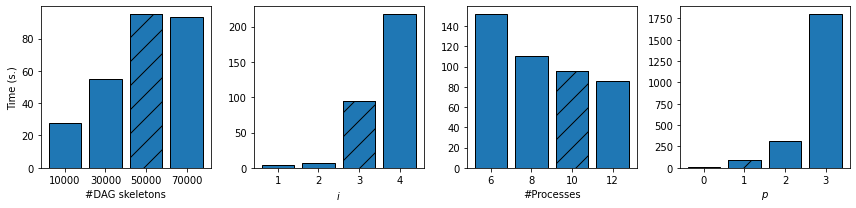

In [10]:
crits = [('df', '#DAG skeletons'), ('inter', r'$i$'), ('proc', '#Processes'), ('params', r'$p$')]
ranges = {crit : sorted(list(set([x[i] for x in res_dict.keys()]))) for i, (crit, _) in enumerate(crits)}


#configs = [(0, True)] + [(i+1, False) for i in range(len(crits)-1)]
fs = 3.0
fig, axs = plt.subplots(nrows = 1, ncols = len(crits), figsize = (fs*len(crits), fs))

configs = [(0, True, axs[0])] + [(i+1, False, axs[i+1]) for i in range(len(crits)-1)]
for idx, addy, ax in configs:
    crit, crit_name = crits[idx]
    
    x_values = []
    y_values = []
    for x in ranges[crit]:
        tmp = list(default_setting)
        tmp[idx] = x
        tmp = tuple(tmp)
        
        if tmp in res_dict:
            x_values.append(x)
            y_values.append(np.mean(res_dict[tmp]))

    ax.bar(range(len(x_values)), y_values, color = 'tab:blue', edgecolor = 'black')
    ax.set_xticks(range(len(x_values)), x_values)
    ax.set_xlabel(crit_name)
    
    if default_setting[idx] in x_values:
        k = x_values.index(default_setting[idx])
        ax.bar([k], y_values[k], color = 'tab:blue', edgecolor = 'black', hatch = '/')
    
    
    #for lab in ax.get_xticklabels():
    #    print(default_setting[idx], int(lab.get_text()))
    #    if int(lab.get_text()) == default_setting[idx]:
    #        lab.set_fontweight('bold')
    #ax.set_yscale('log')

    if addy:
        ax.set_ylabel('Time (s.)')
plt.tight_layout()
plt.savefig(f'results/figures/runtimes.pdf', bbox_inches = 'tight')


## Table: Influence of parameter $p$

Example:
\begin{align}
\frac{1}{3}x^2
\end{align}

In [18]:
# define regression problem
np.random.seed(0)
true_model = sympy.sympify('(x_0^2)/3')
X = np.random.rand(100, 1)
y = (X[:, 0]**2)/3

n_params = [0, 1, 2]
n_intermediary = [0, 1, 2, 3]

res_dict = {} # access via [p][i]


scores = []
models = []

for k in n_params:
    res_dict[k] = {}
    for c in n_intermediary:
        print(f'n_params: {k}, intermediary: {c}')
        est = dag_search.DAGRegressor(n_calc_nodes = c, k = k, max_orders = int(1e4), random_state = 0)
        est.fit(X, y, verbose = 0)
        mse = np.mean((est.predict(X) - y)**2)
        model = str(est.model())
        rec = utils.symb_eq(est.model(), true_model)
        
        res_dict[k][c] = {
            'MSE' : mse,
            'model' : model,
            'recovery' : rec
        }
        

n_params: 0, intermediary: 0
n_params: 0, intermediary: 1
n_params: 0, intermediary: 2
n_params: 0, intermediary: 3
n_params: 1, intermediary: 0
n_params: 1, intermediary: 1
n_params: 1, intermediary: 2
n_params: 1, intermediary: 3
n_params: 2, intermediary: 0
n_params: 2, intermediary: 1
n_params: 2, intermediary: 2
n_params: 2, intermediary: 3


In [19]:
# print a table
#crit = 'recovery'
crit = 'MSE'

# header
s = '\\begin{tabular}{l' + 'c'*len(n_intermediary) + '}'
print(s)
s = '$p$/$i$'
for i in n_intermediary:
    s += f'&{i}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for k in n_params:
    s = str(k)
    for c in n_intermediary:
        if crit in res_dict[k][c]:
            v = res_dict[k][c][crit]
            if 'MSE' in crit:
                v = np.round(v, 4)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccc}
$p$/$i$&0&1&2&3\\
\toprule
0&0.0197&0.0073&0.0002&0.0\\
1&0.0013&0.0&0.0&0.0\\
2&0.0013&0.0&0.0&0.0\\
\end{tabular}


## Figure: Size of Sample Space

In [55]:
# new: with different number of output nodes
def get_n_frames(inp_nodes, inter_nodes, outp_nodes):
    n = inp_nodes
    i = inter_nodes
    r = outp_nodes
    
    if inter_nodes == 0:
        return (n*(n+1))**r
    else:
        S_prev = get_n_frames(inp_nodes, inter_nodes-1, outp_nodes)
        return (S_prev*(n+i)*(n+i+1)**r)//((n+i-1)**(r-1))
    

0 3111696
1 413048832
2 63207309312
3 11110659840000
4 2231428953600000
5 508980018600345600
6 131062163587478323200
7 37878178815332971315200
8 12219462555925008384000000
9 4377631366973950525440000000


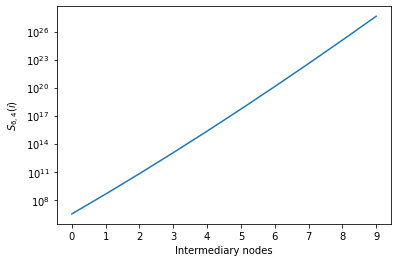

In [57]:
# 1. fix input nodes + outp_nodes, vary intermediate nodes
inp_nodes = 6
outp_nodes = 4 # can be varied now


xs = []
n_frames = []

for i in range(0, 10):
    frames = get_n_frames(inp_nodes, i, outp_nodes)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel(r'$S_{6, 4}(i)$')
plt.xlabel('Intermediary nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)
#plt.savefig(f'results/figures/dagframes_intermediate.pdf', bbox_inches = 'tight')

1 6401203200
2 318637670400
3 6320730931200
4 74071065600000
5 608571532800000
6 3855909231820800
7 20003382720921600
8 88487186064076800
9 343607786121600000


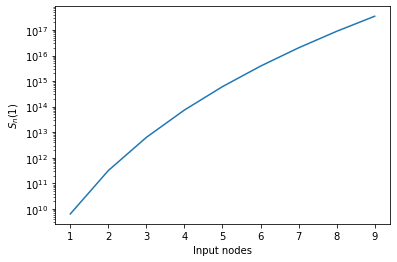

In [88]:
# 1. vary input nodes, fix intermediate nodes + output nodes

inter_nodes = 5
outp_nodes = 3 # can be varied now

xs = []
n_frames = []

for i in range(1, 10):
    frames = get_n_frames(i, inter_nodes, outp_nodes)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel('$S_n(1)$')
plt.xlabel('Input nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)

Old: only one output node

In [2]:
def get_n_frames(inp_nodes, inter_nodes):
    I = inp_nodes
    n = inter_nodes
    ret = I*(I + n + 1)
    for i in range(n):
        ret = ret * (I + (i+1))**2
    return ret

0 6
1 72
2 1440
3 43200
4 1814400
5 101606400
6 7315660800
7 658409472000
8 72425041920000
9 9560105533440000


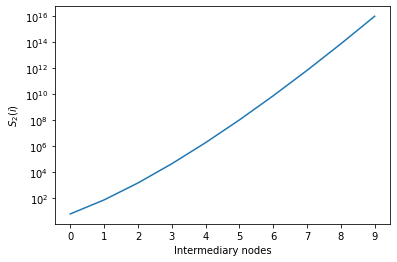

In [5]:
# 1. fix input nodes, vary intermediate nodes
inp_nodes = 2

xs = []
n_frames = []

for i in range(0, 10):
    frames = get_n_frames(inp_nodes, i)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel(r'$S_2(i)$')
plt.xlabel('Intermediary nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)
plt.savefig(f'results/figures/dagframes_intermediate.pdf', bbox_inches = 'tight')

1 12
2 72
3 240
4 600
5 1260
6 2352
7 4032
8 6480
9 9900


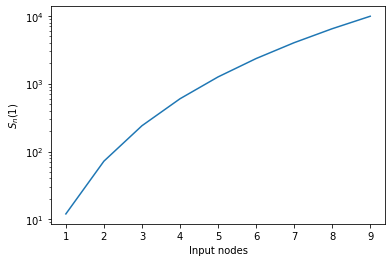

In [7]:
# 1. vary input nodes, fix intermediate nodes

inter_nodes = 1

xs = []
n_frames = []

for i in range(1, 10):
    frames = get_n_frames(i, inter_nodes)
    print(i, frames)
    xs.append(i)
    n_frames.append(frames)
    
    
plt.yscale('log')
plt.ylabel('$S_n(1)$')
plt.xlabel('Input nodes')
plt.xticks(xs)
plt.plot(xs, n_frames)
plt.savefig(f'results/figures/dagframes_input.pdf', bbox_inches = 'tight')

## Nguyen-6

In [18]:
ds_name = 'Nguyen'
problem_name = 'Nguyen-6'

load_path = f'results/{ds_name}/{problem_name}_single.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)

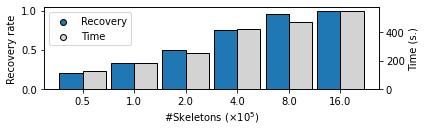

In [20]:
orders = sorted(list(res_dict.keys()))
avg_rec = [np.mean(res_dict[o]['recovery']) for o in orders]
avg_time = [np.mean(res_dict[o]['times']) for o in orders] # log?
k = len(avg_rec)
spacing = 0.05 # change spacing here
v = 1 - 2*spacing
width = 0.5*v

fs = 1.0

fig, ax1 = plt.subplots(figsize = (k*fs, 1.5*fs))
ax2 = ax1.twinx()

# barplot
#positions = range(k)
positions = [i - 0.25*v for i in range(k)]
ax1.bar(positions, avg_rec, width = width, color = 'tab:blue', edgecolor='black') 
ax1.set_ylabel('Recovery rate')


#positions = range(k)
positions = [i + 0.25*v for i in range(k)]
ax2.bar(positions, avg_time, width = width, color = 'lightgray', edgecolor='black')
ax2.set_ylabel('Time (s.)')



round_orders = [o/int(10**5) for o in orders]
plt.xticks(range(k), round_orders)

plt.scatter([], [], edgecolor='black', color = 'tab:blue', label = 'Recovery')
plt.scatter([], [], edgecolor='black', color = 'lightgray', label = 'Time')
plt.legend()
#plt.ylim(0.0, 1.1)

# plot dotted line
#tmp = [p.get_width() for p in plt.gca().patches]
#plt.plot([0-tmp[0]/2, len(avgs)-1 + tmp[-1]/2], [1, 1], color = 'gray', linestyle = '--')
ax1.set_xlabel('#Skeletons ' + r'$(\times 10^5)$')
plt.savefig(f'results/figures/dagframes_{problem_name}.pdf', bbox_inches = 'tight')

## Examples for partial recovery

In [17]:
ds_name = 'Feynman_bonus'
regressor_name = 'DAGSearch'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/{regressor_name}_results.p'
with open(load_path, 'rb') as handle:
    results_dict = pickle.load(handle)

Soft measure of recovery:

- $S_i$... set of simplified subexpressions for expression $e_i$

Jaccard-Index
\begin{align}
J(S_0, S_1) = \cfrac{|S_0\cap S_1|}{|S_0\cup S_1|}
\end{align}

- $J\in [0, 1]$ 
- $J = 1$ if $S_0 = S_1$

In [18]:
jaccard_idxs = []
recs = []
problems = []
for problem_name in results_dict.keys():
    expr_est = results_dict[problem_name]['exprs'][0]
    expr_true = task_dict[problem_name]['expr'][0]
    ji = utils.jaccard_idx(expr_est, expr_true)
    rec = results_dict[problem_name]['recovery'][0]
    print(problem_name, rec, ji)
    jaccard_idxs.append(ji)
    recs.append(int(rec))
    problems.append(problem_name)
jaccard_idxs = np.array(jaccard_idxs)
recs = np.array(recs)

test_1 False 0.15151515151515152
test_11 False 0.13043478260869565
test_12 False 0.24
test_13 False 0.25925925925925924
test_14 False 0.18518518518518517
test_15 False 0.19230769230769232
test_16 False 0.16
test_17 False 0.391304347826087
test_18 False 0.2727272727272727
test_19 False 0.3333333333333333
test_2 False 0.25
test_20 False 0.3333333333333333
test_3 False 0.34782608695652173
test_4 False 0.25925925925925924
test_5 False 0.15
test_6 False 0.16129032258064516
test_7 False 0.23809523809523808
test_8 False 0.22727272727272727
test_9 False 0.3333333333333333


In [20]:
np.mean(jaccard_idxs)

0.2429724908207229

In [12]:
values = np.maximum(recs, jaccard_idxs)
sort_idx = np.argsort(jaccard_idxs)
for i in sort_idx:
    print(problems[i], jaccard_idxs[i])

test_11 0.13043478260869565
test_5 0.15
test_1 0.15151515151515152
test_16 0.16
test_6 0.16129032258064516
test_14 0.18518518518518517
test_15 0.19230769230769232
test_8 0.22727272727272727
test_7 0.23809523809523808
test_12 0.24
test_2 0.25
test_13 0.25925925925925924
test_4 0.25925925925925924
test_18 0.2727272727272727
test_19 0.3333333333333333
test_20 0.3333333333333333
test_9 0.3333333333333333
test_3 0.34782608695652173
test_17 0.391304347826087


In [9]:
problem_name = 'II.6.11'
expr_est = results_dict[problem_name]['exprs'][0]
expr_true = task_dict[problem_name]['expr'][0]
expr_est, expr_true

(0.09577*x_1*cos(x_2)/(x_0**(3/2)*x_3**2), x_1*cos(x_2)/(4*pi*x_0*x_3**2))

In [10]:
utils.jaccard_idx(expr_est, expr_true)

0.4666666666666667

## Table: Comparison to ESR

Takeaway: Our Approach is better than ESR (in all Aspects)

In [113]:
import pickle
regs = ['esr', 'DAGSearch', 'DAGSearchPoly']
ds_name = 'Univ' # Strogatz, Feynman, Nguyen, Univ  

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
# collect results
from sklearn.metrics import r2_score
res = {}
for regressor_name in regs:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            #for rec in results_dict[problem]['recovery']:
            #    recoveries.append(rec)
            for y, pred, rec in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test'], results_dict[problem]['recovery']):
                r2 = r2_score(y, pred)
                recoveries.append(rec or r2==1.0)
        res[regressor_name]['recovery'] = np.mean(recoveries)


        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(expr))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.mean(expr_sizes)
            
        # processing times
        time = 0.0
        counter = 0
        for problem in results_dict.keys():
            for t in results_dict[problem]['times']:
                time += t
                counter += 1
        time = time/counter
        
        res[regressor_name]['time'] = time

In [114]:
# Make Table
reg_names = {
    'esr' : 'ESR',
    'DAGSearch' : 'USDF',
    'DAGSearchPoly' : 'USDF + Aug'
}

crit_names = {
    'recovery' : 'Rec',
    #'rmse_train' : 'RMSE Train',
    #'rmse_test' : 'RMSE Test',
    #'r2_train' : '$R^2$ Train',
    'r2_test' : '$R^2$',
    'complexity' : 'Complexity',
    'time' : 'Time'
}

# print a table
regs = list(res.keys())
crits = list(crit_names.keys())
sort_idx = np.argsort([-res[reg]['recovery'] for reg in regs])
regs = [regs[i] for i in sort_idx]

# header
s = '\\begin{tabular}{l' + 'c'*len(crits) + '}'
print(s)
s = ''
for crit in crits:
    s += f'&{crit_names[crit]}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for reg in regs:
    s = reg_names[reg]
    for crit in crits:
        if crit in res[reg]:
            v = res[reg][crit]
            if 'r2' in crit:
                v = np.round(v, 2)
            else:
                v = np.round(v, 2)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccc}
&Rec&$R^2$&Complexity&Time\\
\toprule
USDF + Aug&1.0&1.0&9.3&26.12\\
USDF&0.8&1.0&9.4&388.82\\
ESR&0.5&1.0&9.7&1293.63\\
\end{tabular}


## Figure: Timing

Takeaway: Our Approach is highly parallelizable

In [115]:
ds_names = ['Univ', 'Nguyen', 'Feynman', 'Strogatz']

results = {}

for ds_name in ds_names:
    load_path = f'datasets/{ds_name}/tasks.p'
    with open(load_path, 'rb') as handle:
        task_dict = pickle.load(handle)

    load_path = f'results/{ds_name}/timings.p'
    if os.path.exists(load_path):
        with open(load_path, 'rb') as handle:
            res_dict = pickle.load(handle)

        problems = list(res_dict.keys())
        n_processes = sorted(list(res_dict[problems[0]].keys()))
        # res_dict[problem][n_processes] = all_times
        # collect average times per number of processes

        avg_times = []
        for n_p in n_processes:
            times = []
            for problem in problems:
                if n_p in res_dict[problem]:
                    times.append(np.mean(res_dict[problem][n_p]))
            avg_times.append(np.mean(times))

        
        results[ds_name] = {}
        for n_p, t in zip(n_processes, avg_times):
            results[ds_name][n_p] = t

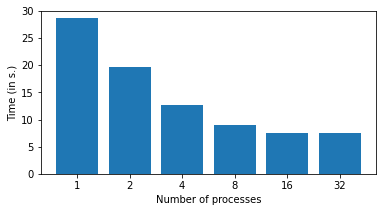

In [116]:
ds_name = 'Feynman'
fig = plt.figure(figsize = (6, 3))
cores = sorted(list(results[ds_name].keys()))
times = [results[ds_name][c] for c in cores]
plt.bar(range(len(cores)), times)
plt.xticks(range(len(cores)), cores)
plt.xlabel('Number of processes')
plt.ylabel('Time (in s.)')
plt.savefig(f'results/figures/times_{ds_name}.pdf', bbox_inches = 'tight')

In [117]:
# print table
ds_name = 'Feynman'
n_round = 2
cores = sorted(list(results[ds_name].keys()))
times = [results[ds_name][c] for c in cores]

# header
s = '\\begin{tabular}{l' + 'c'*len(cores) + '}'
print(s)


s = 'Processes'
for c in cores:
    v = c
    s += f'&{v}'
s += '\\\\'
print(s)
print('\\midrule')


s = 'Time (in s.)'
for t in times:
    v = np.round(t, n_round)
    s += f'&{v}'
s += '\\\\'
print(s)

s = '\\end{tabular}'
print(s)

\begin{tabular}{lcccccc}
Processes&1&2&4&8&16&32\\
\midrule
Time (in s.)&28.61&19.68&12.63&8.92&7.46&7.58\\
\end{tabular}


## Scalability

Takeaway: Our Approach has potential to scale with

- number of calculation nodes (= max size of expression)
- number of orders (= coverage)

In [23]:
ds_name = 'Feynman'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/scalings.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)

seeds = sorted(list(res_dict.keys()))
nodes = sorted(list(res_dict[seeds[0]].keys()))
orders = sorted(list(res_dict[seeds[0]][nodes[0]].keys()))
problems = list(task_dict.keys())

# average results for each seed 
# how to access: [rand_state][n_calc_nodes][max_orders][problem]

recovery_results = {}
time_results = {}
for n_calc_nodes in nodes:
    recovery_results[n_calc_nodes] = {}
    time_results[n_calc_nodes] = {}
    
    for max_orders in orders:
        all_recs = []
        all_times = []
        for seed in seeds:
            recs = []
            times = []
            
            if (n_calc_nodes in res_dict[seed]) and (max_orders in res_dict[seed][n_calc_nodes]):  
                #for problem in res_dict[seed][n_calc_nodes][max_orders]:
                for problem in res_dict[seed][n_calc_nodes][max_orders]:
                    recs += res_dict[seed][n_calc_nodes][max_orders][problem]['recovery']
                    times += res_dict[seed][n_calc_nodes][max_orders][problem]['times']
                avg_rec = np.mean(recs)
                avg_time = np.mean(times)

                all_recs.append(avg_rec)
                all_times.append(avg_time)
        # here we have lists with avg results for each seed    
        
        if len(all_recs) > 0:
        
            recovery_results[n_calc_nodes][max_orders] = np.mean(all_recs)
            time_results[n_calc_nodes][max_orders] = np.mean(all_times)

In [24]:
# print table
#table_data, n_round = recovery_results, 2
table_data, n_round = time_results, 1


# header
s = '\\begin{tabular}{c' + 'l'*len(orders) + '}'
print(s)

s = '$i$/$d$' # insert diag cell here
for o in orders:
    v = o//(10**3)
    s += f'&{v}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for n_calc_nodes in nodes:
    s = str(n_calc_nodes)
    for o in orders:
        if n_calc_nodes in table_data:
            if o in table_data[n_calc_nodes]:
                v = np.round(table_data[n_calc_nodes][o], n_round)
                if n_round == 0:
                    v = int(v)
                s += f'&{v}'
                  
            else:
                s += '&-'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{cllll}
$i$/$d$&10&20&40&80\\
\toprule
1&5.4&5.5&5.8&5.9\\
2&7.4&7.7&9.3&10.8\\
3&8.9&12.4&17.4&27.6\\
4&15.1&20.7&27.9&43.8\\
\end{tabular}


The computational cost however grows exponentially

In [26]:
nodes, orders

([1, 2, 3, 4], [10000, 20000, 40000, 80000])

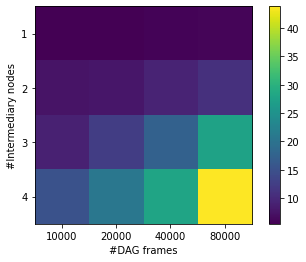

In [36]:
heatmap = np.zeros((len(nodes), len(orders)))
for i, n in enumerate(nodes):
    for j, o in enumerate(orders):
        heatmap[i, j] = time_results[n][o]
        
plt.imshow(heatmap)

plt.xticks(range(len(orders)), orders)
plt.yticks(range(len(nodes)), nodes)
plt.xlabel('#DAG frames')
plt.ylabel('#Intermediary nodes')
plt.colorbar()

## Figure: We solve all small Problems

In [47]:
ds_name = 'Strogatz'
regressor = 'DAGSearch'
#regressor = 'DAGSearchPoly'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path = f'results/{ds_name}/{regressor}_results.p'
with open(load_path, 'rb') as handle:
    res_dict = pickle.load(handle)


In [48]:
problems = res_dict.keys()

problem_sizes = []
recs = []
problem_names = []
for problem in problems:
    r = res_dict[problem]['recovery']
    for i in range(len(r)):
        recs.append(r[i])
        expr = task_dict[problem]['expr'][i]
        problem_sizes.append(utils.tree_size(expr))
        if len(r) > 1:
            problem_names.append(f'{problem}_{i}')
        else:
            problem_names.append(f'{problem}')

In [49]:
sort_idx = np.argsort(problem_sizes)
problem_sizes = [problem_sizes[i] for i in sort_idx]
problem_names = [problem_names[i] for i in sort_idx]
recs = [recs[i] for i in sort_idx]

rec_idxs = [i for i in range(len(recs)) if recs[i]]
not_rec_idxs = [i for i in range(len(recs)) if not recs[i]]

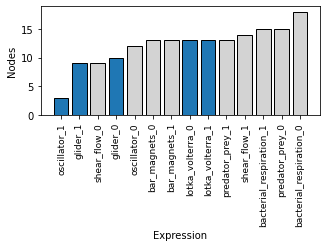

In [50]:
#fig = plt.figure(figsize = (15, 2)) # for feynman
fig = plt.figure(figsize = (5, 2))
# 1. plot recovered problems
plt.bar(rec_idxs, [problem_sizes[i] for i in rec_idxs], color = 'tab:blue', edgecolor = 'black')

# 2. plot not recovered problems
plt.bar(not_rec_idxs, [problem_sizes[i] for i in not_rec_idxs], color = 'lightgray', edgecolor = 'black')

# 3. add legend
plt.scatter([], [], color = 'tab:blue', label = 'recovered')
plt.scatter([], [], color = 'lightgray', label = 'not recovered')
#plt.legend()


# 4. add writing
plt.xticks(range(len(recs)), problem_names, rotation = 90)
plt.gca().tick_params(axis='x', which='major', labelsize=9)
plt.ylabel('Nodes')
plt.xlabel('Expression')
#plt.title(f'{regressor} - {ds_name}')
plt.savefig(f'results/figures/problem_sizes_{ds_name}_{regressor}.pdf', bbox_inches = 'tight')
plt.show()

In [2]:
# for paper: two plots next to each other 

ds_name = 'Nguyen'
regressor1 = 'DAGSearch'
regressor2 = 'DAGSearchPoly'

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
    
load_path1 = f'results/{ds_name}/{regressor1}_results.p'
with open(load_path1, 'rb') as handle:
    res_dict1 = pickle.load(handle)
    
load_path2 = f'results/{ds_name}/{regressor2}_results.p'
with open(load_path2, 'rb') as handle:
    res_dict2 = pickle.load(handle)

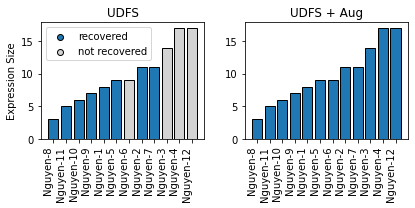

In [3]:
problems = res_dict1.keys()

problem_sizes = []
recs1 = []
recs2 = []
problem_names = []
for problem in problems:
    r1 = res_dict1[problem]['recovery']
    r2 = res_dict2[problem]['recovery']
    for i in range(len(r1)):
        recs1.append(r1[i])
        recs2.append(r2[i])
        expr = task_dict[problem]['expr'][i]
        problem_sizes.append(utils.tree_size(expr))
        if len(r1) > 1:
            problem_names.append(f'{problem}_{i}')
        else:
            problem_names.append(f'{problem}')
            
sort_idx = np.argsort(problem_sizes)
problem_sizes = [problem_sizes[i] for i in sort_idx]
problem_names = [problem_names[i] for i in sort_idx]
recs1 = [recs1[i] for i in sort_idx]
recs2 = [recs2[i] for i in sort_idx]

rec_idxs1 = [i for i in range(len(recs1)) if recs1[i]]
not_rec_idxs1 = [i for i in range(len(recs1)) if not recs1[i]]
rec_idxs2 = [i for i in range(len(recs2)) if recs2[i]]
not_rec_idxs2 = [i for i in range(len(recs2)) if not recs2[i]]


fs = 3.0
fig, axs = plt.subplots(ncols = 2, figsize = (2*fs, fs))


for i, (rec_idxs, not_rec_idxs, title) in enumerate([(rec_idxs1, not_rec_idxs1, 'UDFS'), (rec_idxs2, not_rec_idxs2, 'UDFS + Aug')]):
    # 1. plot recovered problems
    axs[i].bar(rec_idxs, [problem_sizes[i] for i in rec_idxs], color = 'tab:blue', edgecolor = 'black')

    # 2. plot not recovered problems
    axs[i].bar(not_rec_idxs, [problem_sizes[i] for i in not_rec_idxs], color = 'lightgray', edgecolor = 'black')

    # 4. add writing
    axs[i].set_xticks(range(len(recs1)), problem_names, rotation = 90, ha='right')
    #axs[i].tick_params(axis='x', which='major', labelsize=9)
    if i == 0:
        axs[i].set_ylabel('Expression Size')
        
    axs[i].set_title(title)
    #axs[i].set_xlabel('Expression')

# 3. add legend
axs[0].scatter([], [], color = 'tab:blue', label = 'recovered', edgecolor = 'black')
axs[0].scatter([], [], color = 'lightgray', label = 'not recovered', edgecolor = 'black')
axs[0].legend()

plt.tight_layout()

#plt.title(f'{regressor} - {ds_name}')
plt.savefig(f'results/figures/problem_sizes_{ds_name}.pdf', bbox_inches = 'tight')
plt.show()

## Figure: Flowchart

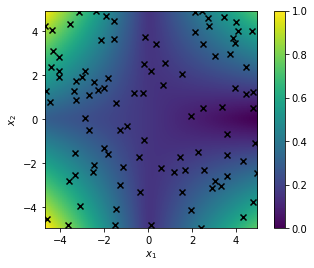

In [63]:
def func(x0, x1):
    return np.sqrt((x0*x1)**2 + 1) - x0

X = np.random.rand(100, 2)*10-5
y = func(X[:, 0], X[:, 1])

# Set up a regular grid of interpolation points
x0, x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
x0, x1 = np.meshgrid(x0, x1)
ys = func(x0, x1)


plt.imshow(ys, vmin=ys.min(), vmax=ys.max(), origin='lower',extent=[X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()])
#plt.scatter(x, y, c=z)

plt.scatter(X[:, 0], X[:, 1], color = 'black', marker = 'x')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.colorbar()
plt.savefig(f'results/figures/workflow1.pdf', bbox_inches = 'tight')

## Figure: Hierarchical Grid Search

In [149]:
# true expression: (x + c)**2
node_dict = {
    0 : ([], 'inp'), # x
    1 : ([], 'const'), # c
    2 : ([3], 'sq'), # (x+c)**2
    3 : ([0, 1], 'sub_l'), # x+c
}
graph = comp_graph.CompGraph(m = 1, n = 1, k = 1, node_dict = node_dict)
graph.evaluate_symbolic()

[(-c_0 + x_0)**2]

In [243]:
X = np.random.rand(100, 1)*5-2.5
y = (X[:, 0] - np.sqrt(2))**2

loss_fkt = dag_search.MSE_loss_fkt(y)

In [244]:
interval_upper, interval_lower = 2, 1
n_steps = 8
n_zooms = 3

all_losses = []
all_c = []
all_loss = []
all_values = []


k = graph.n_consts
interval_size = interval_upper - interval_lower
c = (interval_upper + interval_lower)/2*np.ones(k)
stepsize = interval_size/(n_steps - 1)
for zoom in range(n_zooms):
    c_init = c

    c_init = c_init*np.ones(k)

    l = interval_size/2
    values = np.linspace(-l, l, n_steps)
    tmp = np.meshgrid(*[values]*k)
    consts = np.column_stack([x.flatten() for x in tmp])
    consts = consts + np.stack([c_init]*len(consts))

    losses = loss_fkt(X, graph, consts)
    
    

    best_idx = np.argmin(losses)
    c = consts[best_idx]
    loss = losses[best_idx]
    
    print(c[0], loss)
    
    all_losses.append(losses)
    all_c.append(c[0])
    all_loss.append(loss)
    all_values.append(consts[:, 0])
    
    interval_size = 2*stepsize
    stepsize = interval_size/(n_steps - 1)



1.4285714285714286 0.003376192800870981
1.4081632653061225 0.0005951642993750463
1.41399416909621 7.84213261392799e-07


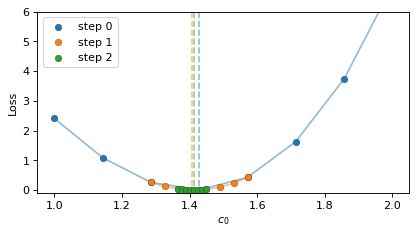

In [256]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
min_v = 0.0
max_v = 6
fig = plt.figure(figsize=(6, 3), dpi=80)

for i, (values, losses) in enumerate(zip(all_values, all_losses)):
    c = colors[i%len(all_values)]
    plt.plot(values, losses, color = c, alpha = 0.5)
    plt.scatter(values, losses, color = c, linewidth = 0.2, zorder = 2, edgecolor='black', label = f'step {i}')
    min_c = values[np.argmin(losses)]
    
    
    plt.plot([min_c, min_c], [max_v, min_v], color = c, linestyle = '--', alpha = 0.5)
    
#plt.plot([np.pi, np.pi], [max_v, min_v], color = 'black', linestyle = '--', alpha = 0.5)
plt.ylim((min_v - 0.1, max_v))
plt.legend()
plt.xlabel(r'$c_0$')
plt.ylabel('Loss')
plt.savefig(f'results/figures/grid_search_example.pdf', bbox_inches = 'tight')

## Damped Pendulum

$y(t)=e^{-t}\cos(2\pi t)$

$0.06\cos(4x)+0.13\cos(5x)+0.30\cos(6x)+0.23\cos(7x)+0.08\cos(8x)$


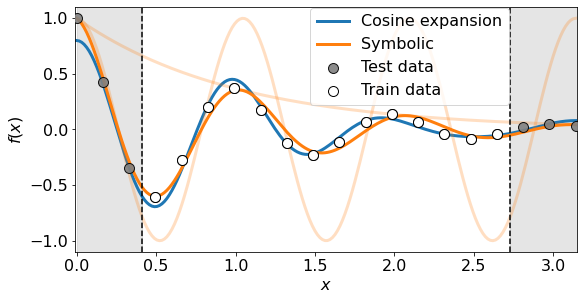

In [73]:
import numpy as np
import matplotlib.pyplot as plt

osci = lambda x : np.cos(6 * x)
decay = lambda x : np.exp(-x)

x = np.linspace(0.0, 2 * np.pi, 20) / 2
#data = x, osci(x) * decay(x)
data = x, np.exp(-x)*np.cos(2*np.pi*x)
data_train = data[0][3:-3], data[1][3:-3]
data_train = data

d = 10
X = np.cos(np.multiply.outer(data_train[0], np.arange(d)))
p = np.linalg.pinv(X) @ data_train[1]
#p = p*100
p = np.round(p, 2) * 100
p[p <= 5] = 0
model = lambda x : np.cos(np.multiply.outer(x, np.arange(d))) @ p / 100
#model = lambda x : (7 * np.cos(4 * x) + 17 * np.cos(5 * x) + 31 * np.cos(6 * x) + 17 * np.cos(7 * x) + 7 * np.cos(8 * x)) / 100
model_label = "+".join([f"{pp:.2f}\cos({n}x)" for n, pp in enumerate(p/100)
                        if pp > 0])
model_label = rf"${model_label}$"                         
#model_label = "+".join([f"{pp:.0f}\cos({n}x)" for n, pp in enumerate(p) if pp > 0])
print(model_label)
model_label = rf"$({model_label})/100$"
model_label = "Cosine expansion"

x = np.linspace(data[0].min(), data[0].max(), 10 * len(data[0]))


plt.close("all")
#plt.rc("font", size=16)

fig, ax = plt.subplots(figsize=(9, 4.5))

ax.plot(x, model(x), color="tab:blue", label=model_label, lw=3)
ax.plot(x, osci(x) * decay(x), color="tab:orange", label="Symbolic", lw=3)
ax.plot(x, osci(x), color="tab:orange", lw=3, alpha=0.25)#, ls='--')#, label=r"$\cos(6x)$")
ax.plot(x, decay(x), color="tab:orange", lw=3, alpha=0.25)#, ls='-.')#, label=r"$\exp(-x)$")

ax.scatter(*data, s=100, facecolor="gray", edgecolor="k", zorder=9, alpha=0.9,
           label="Test data")
ax.scatter(data[0][3:-3], data[1][3:-3], s=100, facecolor="w", edgecolor="k",
           zorder=10, label="Train data")

ax.set_xlim(x.min() - 0.01, x.max() + 0.01)
ax.set_ylim(-1.1, 1.1)

xx = 0.5 * (data[0][2] + data[0][3])
ax.axvline(xx, ls='--', color="k")
ax.fill_betweenx([-2, 2], 0., xx, color="k", alpha=0.1)

xx = 0.5 * (data[0][-4] + data[0][-3])
ax.axvline(xx, ls='--', color="k")
ax.fill_betweenx([-2, 2], xx, x.max() + 0.1, color="k", alpha=0.1)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

#ax.legend()
ax.legend(bbox_to_anchor=(0.88,1.03), loc="upper right",)
#fig.savefig("/tmp/fig1.pdf")

plt.savefig(f'results/figures/intro_example.pdf', bbox_inches = 'tight')

In [2]:
np.random.seed(0)
x_values = np.linspace(0, 0.75, 1000).reshape(-1, 1)
X = np.linspace(0, 0.75, 20).reshape(-1, 1)
y = np.exp(-X[:, 0])*np.cos(2*np.pi*X[:, 0])

In [3]:
split_idx = 3, 17
X_train = X[split_idx[0]:split_idx[1], :]
y_train = y[split_idx[0]:split_idx[1]]
X_test = np.concatenate([X[:split_idx[0], :], X[split_idx[1]:, :]])
y_test = np.concatenate([y[:split_idx[0]], y[split_idx[1]:]])

In [4]:
import importlib
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, Ridge
importlib.reload(sklearn)

<module 'sklearn' from 'C:\\Users\\Paul Kahlmeyer\\anaconda3\\envs\\SymbReg\\lib\\site-packages\\sklearn\\__init__.py'>

In [11]:
from regressors import regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge

np.random.seed(0)
regr = regressors.PolyReg(4)
regr.regr = Ridge(alpha = 1e-8, max_iter=100000)

regr.fit(X_train, y_train)
pred_poly = regr.predict(x_values)

pred_symb = np.exp(-x_values[:, 0])*np.cos(6*x_values[:, 0])
pred_decay = np.exp(-x_values[:, 0])
pred_oscillation = np.cos(6*x_values[:, 0])

In [18]:
regr.model()

-39.7961470534699*x_0**4 + 68.6613757490109*x_0**3 - 31.445608444367*x_0**2 + 0.446671568434552*x_0 + 0.935517581468656

(-0.695278112275183, 1.080727529155961)

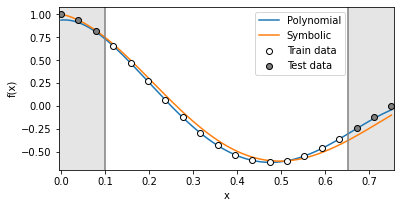

In [7]:
fig = plt.figure(figsize = (6, 3))
offset = 0.005
xlim = (np.min(X)-offset, np.max(X)+offset)
plt.xlim(xlim)

plt.plot(x_values, pred_poly, color ='tab:blue', label = 'Polynomial')
plt.plot(x_values, pred_symb, color ='tab:orange', label = 'Symbolic')
#plt.plot(x_values, pred_decay, color ='tab:orange', label = 'Decay', linestyle = '--')
#plt.plot(x_values, pred_oscillation, color ='tab:cyan', label = 'Oscillation', linestyle = '--')
plt.scatter(X_train, y_train, color = 'white', zorder = 2, edgecolors='black', label = 'Train data')
plt.scatter(X_test, y_test, color = 'tab:gray', zorder = 2, edgecolors='black', label = 'Test data')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(bbox_to_anchor=(0.87,1.0), loc="upper right",)

# gray out test area
lower = 0.5*(X[split_idx[0]-1, 0]+X[split_idx[0], 0])
upper = 0.5*(X[split_idx[1]-1, 0]+X[split_idx[1], 0])
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.axvspan(upper, xlim[-1], facecolor='tab:gray', alpha=0.2)
ax.axvspan(xlim[0], lower, facecolor='tab:gray', alpha=0.2)
plt.plot([lower, lower], ylim, color = 'tab:gray', linestyle = '-')
plt.plot([upper, upper], ylim, color = 'tab:gray', linestyle = '-')
plt.xlim(xlim)
plt.ylim(ylim)

#plt.savefig(f'results/figures/intro_example.pdf', bbox_inches = 'tight')

# !!Not used!!

## Price Theorem does not hold here

If occurence of a Trait in population correlates positively with fitness of population, it will occur more often.

Here: Track fitness of population and occurences of traits of target expression

Trait = Subexpression

In [141]:
ds_name = 'Feynman'

load_path = f'results/{ds_name}/covariances.p'
with open(load_path, 'rb') as handle:
    results_dict = pickle.load(handle)

In [142]:
problems = list(results_dict.keys())
nmb_traits = np.array([len(results_dict[problem_name]['covariances']) for problem_name in results_dict])
max_traits = max(nmb_traits)


sort_idx = np.argsort(-nmb_traits)
problems = [problems[i] for i in sort_idx]

disp_matrix = -np.ones((max_traits, len(results_dict)))

for i, problem in enumerate(problems):
    covs = results_dict[problem]['covariances']
    disp_matrix[:len(covs), i] = covs

Text(0.5, 1.0, 'Feynman')

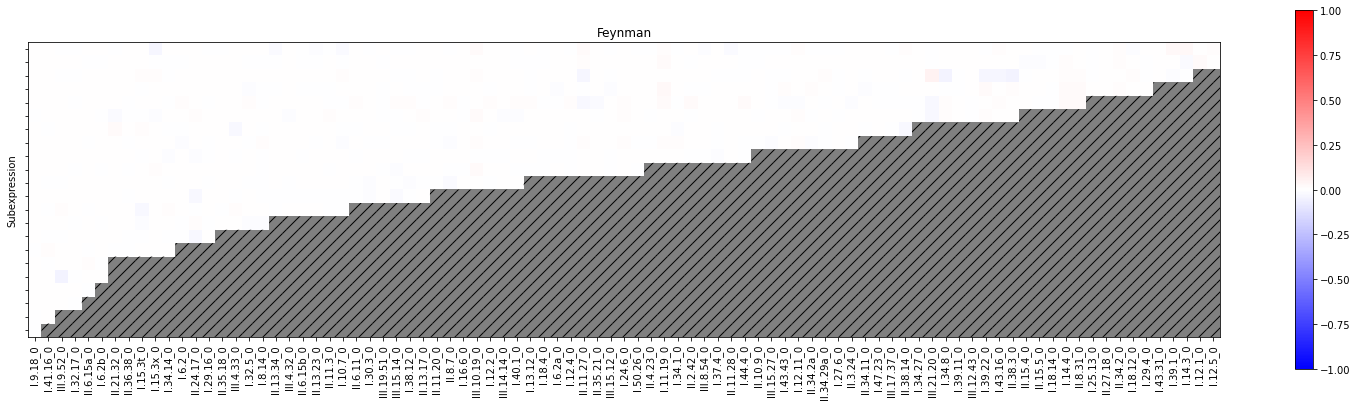

In [143]:
fs = 0.3
plt.figure(figsize = (len(problems)*fs, max_traits*fs))
plt.imshow(disp_matrix, cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()

# add gray hatched area
tmp_img = (disp_matrix == -1).astype(float)
tmp_img[tmp_img == 0] = np.nan
mask = ~np.isnan(tmp_img)
tmp_img[mask] = 0.5
plt.imshow(tmp_img, cmap = 'gray', vmin = 0.0, vmax = 1.0)
zm = np.ma.masked_where(~mask, tmp_img)
plt.pcolor(np.arange(len(problems)), np.arange(max_traits), zm, hatch='//', alpha=0.0)

plt.xticks(range(len(problems)), problems, rotation = 90)
plt.yticks(range(max_traits), [])
plt.ylabel('Subexpression')
plt.title(ds_name)

## Local Minima

For a problem:
- sample population
- connect expressions with edit distance 1
- identify local minima in this population (= all neighbours are worse) 

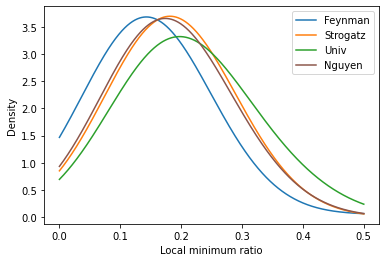

In [145]:
# estimate density
from sklearn.neighbors import KernelDensity
ds_names = ['Feynman', 'Strogatz', 'Univ', 'Nguyen']
ds_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

x_values = np.linspace(0, 0.5, 1000).reshape(-1, 1)

for ds_name, ds_color in zip(ds_names, ds_colors):

    load_path = f'results/{ds_name}/local_minima.p'
    if os.path.exists(load_path):
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)
            
        ratios = np.array([results_dict[p] for p in results_dict])
        kde = KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(ratios.reshape(-1, 1))
        log_densities = kde.score_samples(x_values)

        plt.plot(x_values, np.exp(log_densities), color = ds_color, label = ds_name)


plt.xlabel('Local minimum ratio')
plt.ylabel('Density')
plt.legend()

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/local_minima.pdf', bbox_inches = 'tight')

## Fitness Distance Correlation

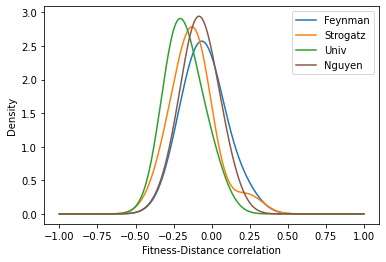

In [368]:
# estimate density
from sklearn.neighbors import KernelDensity
ds_names = ['Feynman', 'Strogatz', 'Univ', 'Nguyen']
ds_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']

x_values = np.linspace(-1, 1, 1000).reshape(-1, 1)

for ds_name, ds_color in zip(ds_names, ds_colors):

    load_path = f'results/{ds_name}/fdc.p'
    with open(load_path, 'rb') as handle:
        results_dict = pickle.load(handle)
    fdcs = np.array([results_dict[p] for p in results_dict])
    kde = KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(fdcs.reshape(-1, 1))
    log_densities = kde.score_samples(x_values)
    
    plt.plot(x_values, np.exp(log_densities), color = ds_color, label = ds_name)


plt.xlabel('Fitness-Distance correlation')
plt.ylabel('Density')
plt.legend()

## Experiment: local minima

Takeaway: Local Search does not work, because we have lots of local minima.

In [71]:
load_path = 'results/local_minima_exp.p'
with open(load_path, 'rb') as handle:
    results = pickle.load(handle)

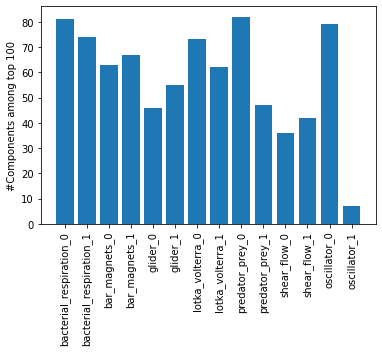

In [72]:
names = list(results.keys())
values = [results[n]['groups'] for n in names]
plt.bar(range(len(names)), values)
plt.xticks(range(len(names)), names, rotation = 90)
plt.ylabel(f'#Components among top {results[names[0]]["topk"]}')

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/local_minima.pdf', bbox_inches = 'tight')

## Experiment: Black Box vs. Symbolic

Takeaway: If you care about model fit, use Black Box. 

In [221]:
import pickle
regs = ['linreg', 'polyreg2', 'polyreg3', 'operon', 'gplearn', 'DAGSearch', 'MLP', 'dsr', 'esr', 'DAGSearch', 'DAGSearchPoly']
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen, Univ  

load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [222]:
len(task_dict.keys())

95

Read Results

In [348]:
regressor_name = 'DAGSearchPoly'
load_path = f'results/{ds_name}/{regressor_name}_results.p'
if os.path.exists(load_path):
    with open(load_path, 'rb') as handle:
        results_dict1 = pickle.load(handle)

regressor_name = 'DAGSearch'
load_path = f'results/{ds_name}/{regressor_name}_results.p'
if os.path.exists(load_path):
    with open(load_path, 'rb') as handle:
        results_dict2 = pickle.load(handle)

In [349]:
for problem_name in results_dict1:
    if problem_name in results_dict2:
        rec1 = results_dict1[problem_name]['recovery'][0]
        rec2 = results_dict2[problem_name]['recovery'][0]
        if rec1 != rec2:
            print(problem_name, rec1, rec2)

I.11.19 True False
I.12.11 True False
I.12.2 True False
I.13.12 True False
I.16.6 True False
I.18.4 True False
I.32.5 True False
I.37.4 True False
I.38.12 True False
II.11.20 True False
II.11.3 True False
II.13.17 True False
II.21.32 True False
II.34.29b True False
II.6.15b True False
III.13.18 True False
III.15.12 True False
III.19.51 True False


In [350]:
p = len(results_dict1)/len(task_dict)
print(f'{round(100*p)}% finished')
for problem in results_dict1:
    print(problem, results_dict1[problem]['recovery'], task_dict[problem]['X'].shape[1])

100% finished
I.10.7 [False] 3
I.11.19 [True] 6
I.12.1 [True] 2
I.12.11 [True] 5
I.12.2 [True] 4
I.12.4 [True] 3
I.12.5 [True] 2
I.13.12 [True] 5
I.13.4 [False] 4
I.14.3 [True] 3
I.14.4 [True] 2
I.15.3t [False] 4
I.15.3x [False] 4
I.16.6 [True] 3
I.18.12 [True] 3
I.18.14 [True] 4
I.18.4 [True] 4
I.24.6 [False] 4
I.25.13 [True] 2
I.27.6 [True] 3
I.29.16 [False] 4
I.29.4 [True] 2
I.30.3 [False] 3
I.32.17 [False] 6
I.32.5 [True] 4
I.34.1 [True] 3
I.34.14 [False] 3
I.34.27 [True] 2
I.34.8 [True] 4
I.37.4 [True] 3
I.38.12 [True] 4
I.39.1 [True] 2
I.39.11 [True] 3
I.39.22 [True] 4
I.40.1 [False] 6
I.41.16 [False] 5
I.43.16 [True] 4
I.43.31 [True] 3
I.43.43 [True] 4
I.44.4 [False] 5
I.47.23 [True] 3
I.50.26 [False] 4
I.6.2 [False] 2
I.6.2a [True] 1
I.6.2b [False] 3
I.8.14 [False] 4
I.9.18 [False] 9
II.10.9 [True] 3
II.11.20 [True] 5
II.11.27 [False] 4
II.11.28 [False] 2
II.11.3 [True] 5
II.13.17 [True] 4
II.13.23 [False] 3
II.13.34 [False] 3
II.15.4 [True] 3
II.15.5 [True] 3
II.2.42 [True] 5


In [351]:
from sklearn.metrics import r2_score
# falsely not recovered expressions
for problem in results_dict1.keys():
    for y, pred, rec in zip(results_dict1[problem]['y_train'], results_dict1[problem]['pred_train'], results_dict1[problem]['recovery']):
        try:
            r2 = r2_score(y, pred)
            
            if r2 == 1.0 and not rec:
                print(problem)
        except:
            print(f'Exception at {problem}')
            pass
    

I.10.7


In [352]:
from sklearn.metrics import r2_score
# read results
res = {}
for regressor_name in regs:
    load_path = f'results/{ds_name}/{regressor_name}_results.p'
    if os.path.exists(load_path):
        res[regressor_name] = {}
        with open(load_path, 'rb') as handle:
            results_dict = pickle.load(handle)

        # avg. recovery
        recoveries = []
        for problem in results_dict.keys():
            #for rec in results_dict[problem]['recovery']:
            #    recoveries.append(rec)
            for y, pred, rec in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test'], results_dict[problem]['recovery']):
                r2 = r2_score(y, pred)
                recoveries.append(rec or r2==1.0)
        res[regressor_name]['recovery'] = np.mean(recoveries)


        # avg. RMSE
        rmses_train = []
        rmses_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_train.append(rmse)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                rmse = np.sqrt(np.mean((y - pred)**2))
                rmses_test.append(rmse)
        res[regressor_name]['rmse_train'] = np.mean(rmses_train)
        res[regressor_name]['rmse_test'] = np.mean(rmses_test)

        # median R2
        r2s_train = []
        r2s_test = []
        for problem in results_dict.keys():
            for y, pred in zip(results_dict[problem]['y_train'], results_dict[problem]['pred_train']):
                r2 = r2_score(y, pred)
                r2s_train.append(r2)
            for y, pred in zip(results_dict[problem]['y_test'], results_dict[problem]['pred_test']):
                r2 = r2_score(y, pred)
                r2s_test.append(r2)
        res[regressor_name]['r2_train'] = np.median(r2s_train)
        res[regressor_name]['r2_test'] = np.median(r2s_test)
            
        # expression size
        expr_sizes = []
        for problem in results_dict.keys():
            for expr in results_dict[problem]['exprs']:
                expr_sizes.append(utils.tree_size(expr))
        if len(expr_sizes) > 0:
            res[regressor_name]['complexity'] = np.mean(expr_sizes)
            
        # processing times
        time = 0.0
        counter = 0
        for problem in results_dict.keys():
            for t in results_dict[problem]['times']:
                time += t
                counter += 1
        time = time/counter
        
        res[regressor_name]['time'] = time

In [353]:
res.keys()

dict_keys(['linreg', 'polyreg2', 'polyreg3', 'operon', 'gplearn', 'DAGSearch', 'MLP', 'dsr', 'DAGSearchPoly'])

In [354]:
res['DAGSearch']

{'recovery': 0.4631578947368421,
 'rmse_train': 3.389036289824608,
 'rmse_test': 3.1634449589587543,
 'r2_train': 0.9993248062119484,
 'r2_test': 0.999393171011008,
 'complexity': 10.726315789473684,
 'time': 278.25504843044143}

In [355]:
res['DAGSearchPoly']

{'recovery': 0.6631578947368421,
 'rmse_train': 0.22866087729835882,
 'rmse_test': 0.24541883464540767,
 'r2_train': 0.9999999998846663,
 'r2_test': 0.999999999882524,
 'complexity': 12.157894736842104,
 'time': 503.0303410742579}

### Plots

In [279]:
reg_names = {
    'esr' : 'ESR',
    'DAGSearch' : 'DAGSearch',
    'DAGSearchPoly' : 'DAGSearchPoly',
    'linreg' : 'LinReg',
    'polyreg2' : 'PolyReg2',
    'polyreg3' : 'PolyReg3',
    'gplearn' : 'GPlearn',
    'dsr' : 'DSR',
    'operon' : 'Operon',
    'MLP' : 'MLP'
}

crit_names = {
    'recovery' : 'Recovery',
    'rmse_train' : 'RMSE Train',
    'rmse_test' : 'RMSE Test',
    'r2_train' : '$R^2$ Train',
    'r2_test' : '$R^2$ Test',
    'complexity' : 'Complexity',
    'time' : 'Processing Time'
}

In [280]:
def get_pareto_idxs(obj1, obj2):
    M = np.column_stack([obj1, obj2])
    ret = []
    for i, p in enumerate(M):
        is_dominated = np.any(np.all(M < p, axis = 1))
        if not is_dominated:
            ret.append(i)
    return np.array(ret)

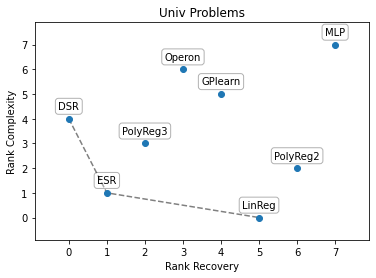

In [281]:
cat_x = 'r2_test'
cat_x = 'recovery'
def_value_x = 0.0
cat_y = 'complexity'
def_value_y = np.inf

# assume lower is better (negate R2, recovery)

regs_present = list(res.keys())
v1 = -np.array([res[regressor_name][cat_x] if cat_x in res[regressor_name] else def_value_x for regressor_name in regs_present])
v2 = np.array([res[regressor_name][cat_y] if cat_y in res[regressor_name] else def_value_y for regressor_name in regs_present])

ranks_x = np.argsort(np.argsort(v1))
ranks_y = np.argsort(np.argsort(v2))


pareto_idxs = get_pareto_idxs(ranks_x, ranks_y)
pareto_idxs = pareto_idxs[np.argsort([ranks_x[i] for i in pareto_idxs])] # sort by x rank (for plotting)

plt.scatter(ranks_x, ranks_y, zorder = 1)
plt.plot([ranks_x[i] for i in pareto_idxs], [ranks_y[i] for i in pareto_idxs], color = 'gray', linestyle = '--', zorder = 0)


# add labels
offset_x = 0.9
offset_y = 0.9
for i in range(len(regs_present)):
    s = reg_names[regs_present[i]]
    x = ranks_x[i]
    y = ranks_y[i] + .3
    ha = 'center'
    va = 'bottom'
    plt.text(s = s, x = x, y = y, ha = ha, va = va, bbox=dict(facecolor='w', edgecolor='black', boxstyle='round', alpha=0.3))
plt.xlim(0-offset_x, len(regs_present)-1+offset_x)
plt.ylim(0-offset_y, len(regs_present)-1+offset_y)
plt.xticks(range(len(regs_present)))
plt.yticks(range(len(regs_present)))

plt.xlabel(f'Rank {crit_names[cat_x]}')
plt.ylabel(f'Rank {crit_names[cat_y]}')
plt.title(f'{ds_name} Problems')


if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig(f'results/figures/scatterplot_{ds_name}.pdf', bbox_inches = 'tight')

In [283]:
# print a table

regs = list(res.keys())
crits = list(res[regs[0]].keys())


sort_idx = np.argsort([-res[reg]['recovery'] for reg in regs])
regs = [regs[i] for i in sort_idx]

# header
s = '\\begin{tabular}{l' + 'l'*len(crits) + '}'
print(s)
s = ''
for crit in crits:
    s += f'&{crit_names[crit]}'
s += '\\\\'
print(s)
print('\\toprule')

# rows
for reg in regs:
    s = reg_names[reg]
    for crit in crits:
        if crit in res[reg]:
            v = res[reg][crit]
            v = np.round(v, 2)
            s += f'&{v}'
        else:
            s += '&-'
    s += '\\\\'
    print(s)
s = '\\end{tabular}'
print(s)

\begin{tabular}{llllllll}
&Recovery&RMSE Train&RMSE Test&$R^2$ Train&$R^2$ Test&Complexity&Processing Time\\
\toprule
DSR&0.6&0.0&0.01&1.0&1.0&15.9&12.48\\
ESR&0.5&0.0&0.01&1.0&1.0&9.7&1293.63\\
PolyReg3&0.2&0.04&0.06&1.0&0.99&15.0&0.0\\
Operon&0.2&0.0&0.01&1.0&1.0&40.0&3.67\\
GPlearn&0.2&0.1&0.11&1.0&1.0&19.6&9.03\\
LinReg&0.1&0.35&0.3&0.7&0.51&5.0&0.0\\
PolyReg2&0.1&0.14&0.13&0.98&0.96&10.0&0.0\\
MLP&0.0&0.92&0.93&1.0&1.0&-&4.24\\
\end{tabular}


## Experiment: Symbolic vs. Numeric Proximity

Fitness Distance Correlation

Takeaway: Symbolic Measures do not correlate with Numeric Measures

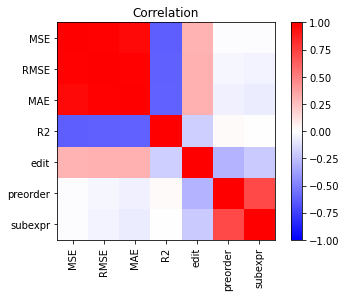

In [83]:
corr_matrix = np.load('results/corr_matrix.npy')
with open(f'results/distance_dict.p', 'rb') as handle:
    dist_dict = pickle.load(handle)
methods = list(dist_dict.keys())


plt.imshow(corr_matrix, vmin = -1, vmax = 1, cmap = 'bwr')
plt.colorbar()
plt.xticks(range(corr_matrix.shape[0]), methods, rotation = 90)
plt.yticks(range(corr_matrix.shape[0]), methods)
plt.title('Correlation')

if not os.path.exists('results/figures'):
    os.mkdirs('results/figures')
plt.savefig('results/figures/corr_plot.pdf', bbox_inches = 'tight')